In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ultrasound-breast-images-for-breast-cancer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2600743%2F4441334%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240302%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240302T075424Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9ad3b3065f0a987110358a9c7fc146d32fab2d458605466c5254efee65ec1e9cc9265094f19ab35e8a840da27f484523cd9316dcae6a0c7041878f199dd8fe9bf9b15bbd23e39dadac4fb608f95088b2092199744076b536424161d528eaaca8dbc6cec4c0a2795c08b031c0bca66ebee188e4e1c2dad64f66e66aa4d25d60909252661a73e28a2511663950ee0044f026a1d6c3b31168c7e41c0373f31e497d8e49df1e3a11e36e6d358e96882decff89eab5bdf1830bc80275b52923e32ec8f80436cec60cb2f0595d116347c34d96effffb939fc320288c874931197569df9ba12c97c045a5573c1251ebd1ca923b58857a45e2b7cecf7730597c4be32865'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


The system cannot find the path specified.


[=                                                 ] 13107200 bytes downloaded

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('T4 GPU')))

Num GPUs Available:  1


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Path to your dataset
base_dir = '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification'

# Rescale the images by dividing every pixel in every image by 255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dir, 'train'),  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 224x224
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        os.path.join(base_dir, 'val'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

Found 8116 images belonging to 2 classes.
Found 900 images belonging to 2 classes.


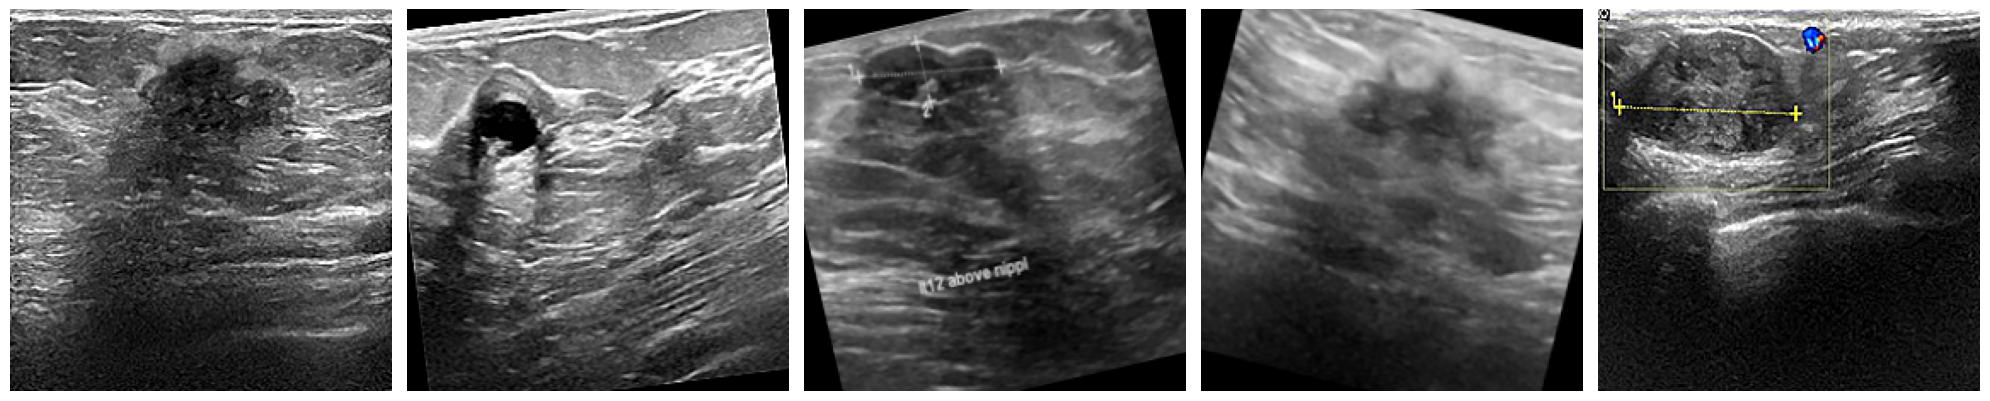

In [7]:
import matplotlib.pyplot as plt

# Function to plot images
def plot_images(images_arr):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Generate a batch of images and labels from the train generator
for image_batch, label_batch in train_generator:
    plot_images(image_batch[:5])  # Plot the first 5 images
    break  # We only need one batch to visualize some samples

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model

# Load the VGG16 network, ensuring the head FC layer sets are left off
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

# Compile the model
model = Model(base_model.input, x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

NameError: name 'tf' is not defined

In [ ]:
# Save the model
model.save('breast_cancer_detector.h5')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Plot training/validation loss and accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict the validation data
model = load_model('breast_cancer_detector.h5')
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    '/kaggle/input/ultrasound-breast-images-for-breast-cancer/ultrasound breast classification/val',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary',
    shuffle=False)

Y_pred = model.predict(val_generator, val_generator.samples // val_generator.batch_size+1)
y_pred = np.where(Y_pred > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(val_generator.classes, y_pred)
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt=".0f", ax=ax)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()